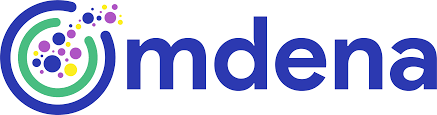,

# Clustering Models for Task 4 - Estimate the Energy Availability 

**Task Goal:** </p>
Members from task 4 extracted solar source data and computed for the PVOut for each municipality. This represents the average estimated energy that can be produced by a single diode solar panel and the 1647 municipalities were clusted based on this.</p>

Two PVOut values were considered for this task: PVOut value from worldbank dataset and computed PVout value using the single diode formula. 

Particularly in this notebook, we consolidated results from task 2 and 4 to identify which areas that will have worst, good and best return of investment (ROI) given by lit per area, solar panel output, and population.

Three models were considered for this tasks: K Means Clustering, Density-based spatial clustering of applications with noise (DBScan), and Gaussian Mixture Modeling (GMM)

The final clustering model to be used on the data was based on their silhoutte scores </p>


### Contents
- Importing Libraries Used
- Importing of Dataset(geojson)
- Prepartion of Dataset 
- Training Models and Deriving for Silhouette Values 
- Comparison and Determination of Models 
- Data Visualization for Clustered Dataset
- Exporting Clustered Dataset

### Libraries and importing of Data

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
from geojson import Point, Feature, FeatureCollection, dump

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score

from scipy.spatial.distance import cdist

%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
ph = gpd.read_file('data/integrated_data_single_diode_pvout.geojson')
ph.head()

,ADM3_EN,ADM3_PCODE,ADM3ALT1EN,ADM2_EN,ADM1_EN,ADM0_EN,mean,total_area,nolit_per,lit_per,GHI,TEMP,PVout,Population,geometry
0,Panglima Sugala,PH157001000,Balimbing,Tawi-Tawi,Autonomous Region in Muslim Mindanao,Philippines (the),0.83074,1.90237,84.33204,15.66796,1768.75519,26.73646,1295.12970,20542.15473,"MULTIPOLYGON (((119.93158 4.90053, 119.93167 4..."
1,Bongao,PH157002000,Capital,Tawi-Tawi,Autonomous Region in Muslim Mindanao,Philippines (the),2.65462,3.16960,26.21539,73.78461,1772.73741,26.96528,1304.74025,52269.20889,"MULTIPOLYGON (((119.76332 5.01178, 119.76282 5..."
2,Mapun,PH157003000,Cagayan de Tawi-Tawi,Tawi-Tawi,Autonomous Region in Muslim Mindanao,Philippines (the),0.55466,1.31950,78.15337,21.84663,1798.93121,26.72738,1339.54399,16606.52010,"MULTIPOLYGON (((118.40042 6.87783, 118.40052 6..."
3,Simunul,PH157004000,None,Tawi-Tawi,Autonomous Region in Muslim Mindanao,Philippines (the),0.75363,1.10777,16.71362,83.28638,1859.88090,27.08906,1438.41764,25882.47008,"MULTIPOLYGON (((119.84475 4.81262, 119.84490 4..."
4,Sitangkai,PH157005000,None,Tawi-Tawi,Autonomous Region in Muslim Mindanao,Philippines (the),1.30635,0.84159,34.51110,65.48890,1830.44474,27.09429,1393.33850,6919.10005,"MULTIPOLYGON (((119.38935 4.61459, 119.38918 4..."


## PVOut value is Computed using the Single Diode Formula

### Preparation of Data for Training Clustering Models

In [3]:
nan_index = ph.index[ph.PVout.isnull()].values
# Impute PV Out based on Location
for index in nan_index:
    loc_name = ph.loc[index,"ADM2_EN"]
    imputed_value = ph[ph['ADM2_EN'] == loc_name].mean().values[0]
    ph.loc[index,'PVout'] = imputed_value
    
nan_index = ph.index[ph.nolit_per.isnull()].values
# Impute No Lit based on Location
for index in nan_index:
    loc_name = ph.loc[index,"ADM1_EN"]
    if loc_name == 'National Capital Region':
        imputed_value = 0 # Min Lit for NCR
    else:
        imputed_value = ph[ph['ADM1_EN'] == loc_name].mean().values[0]
    ph.loc[index,'nolit_per'] = imputed_value
    
nan_index = ph.index[ph.lit_per.isnull()].values
# Impute Lit based on Location
for index in nan_index:
    loc_name = ph.loc[index,"ADM1_EN"]
    if loc_name == 'National Capital Region':
        imputed_value = 100 # Max Lit
    else:
        imputed_value = ph[ph['ADM1_EN'] == loc_name].mean().values[0]

    ph.loc[index,'lit_per'] = imputed_value
    
nan_index = ph.index[ph.Population.isnull()].values
# Impute Population based on Location
for index in nan_index:
    loc_name = ph.loc[index,"ADM2_EN"]
    imputed_value = ph[ph['ADM2_EN'] == loc_name].mean().values[0]
    ph.loc[index,'Population'] = imputed_value

In [4]:
pv_out = ph[['lit_per','PVout','Population']]
pv_out = pv_out.to_numpy()
scaler = RobustScaler()
pv_out= scaler.fit_transform(pv_out)
print(pv_out.shape)

(1647, 3)


### KMeans Clustering Model 

In [5]:
distortions = []
distortion_map = {}

inertias = []
inertia_map = {}

silhouette_scores = []

K = range(2, 20)
 
for k in K:
    # Building and fitting the model
    kmeans = KMeans(n_clusters = k, max_iter=300, random_state = 1234)
    kmeans.fit(pv_out)
    
    # Distortions 
    distortions.append(sum(np.min(cdist(pv_out, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / pv_out.shape[0])
    distortion_map[k] = sum(np.min(cdist(pv_out, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / pv_out.shape[0]
    
    # Inertia
    inertias.append(kmeans.inertia_)
    inertia_map[k] = kmeans.inertia_
    
    pred_clusters = kmeans.predict(pv_out)
    silhouette = silhouette_score(pv_out,pred_clusters)
    silhouette_scores.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(k,silhouette))

Silhouette score for number of cluster(s) 2: 0.8981481615493234
Silhouette score for number of cluster(s) 3: 0.8014842721674662
Silhouette score for number of cluster(s) 4: 0.581086662406244
Silhouette score for number of cluster(s) 5: 0.40850723315986276
Silhouette score for number of cluster(s) 6: 0.33950128152621867
Silhouette score for number of cluster(s) 7: 0.3039184110512332
Silhouette score for number of cluster(s) 8: 0.273426490351565
Silhouette score for number of cluster(s) 9: 0.27796020398775534
Silhouette score for number of cluster(s) 10: 0.28760173608286693
Silhouette score for number of cluster(s) 11: 0.28869475801759226
Silhouette score for number of cluster(s) 12: 0.2704218439296414
Silhouette score for number of cluster(s) 13: 0.26845678601285133
Silhouette score for number of cluster(s) 14: 0.2688603581471585
Silhouette score for number of cluster(s) 15: 0.2712500184220371
Silhouette score for number of cluster(s) 16: 0.26426030916956333
Silhouette score for number 

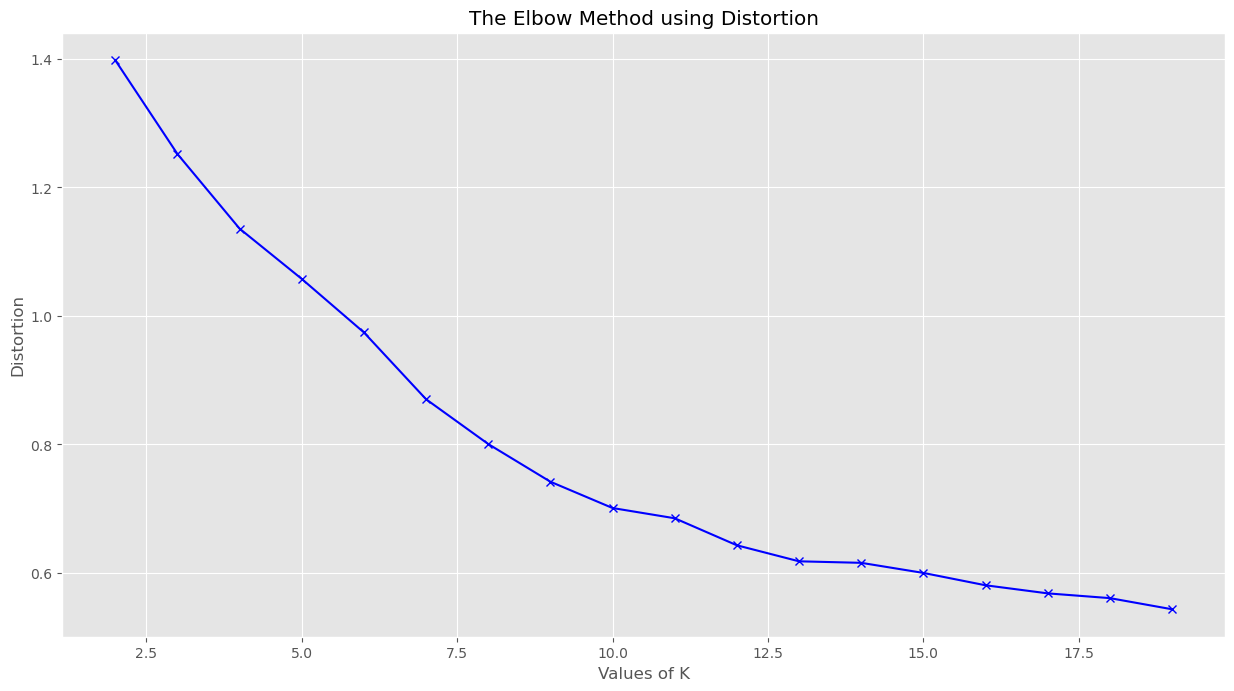

In [6]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

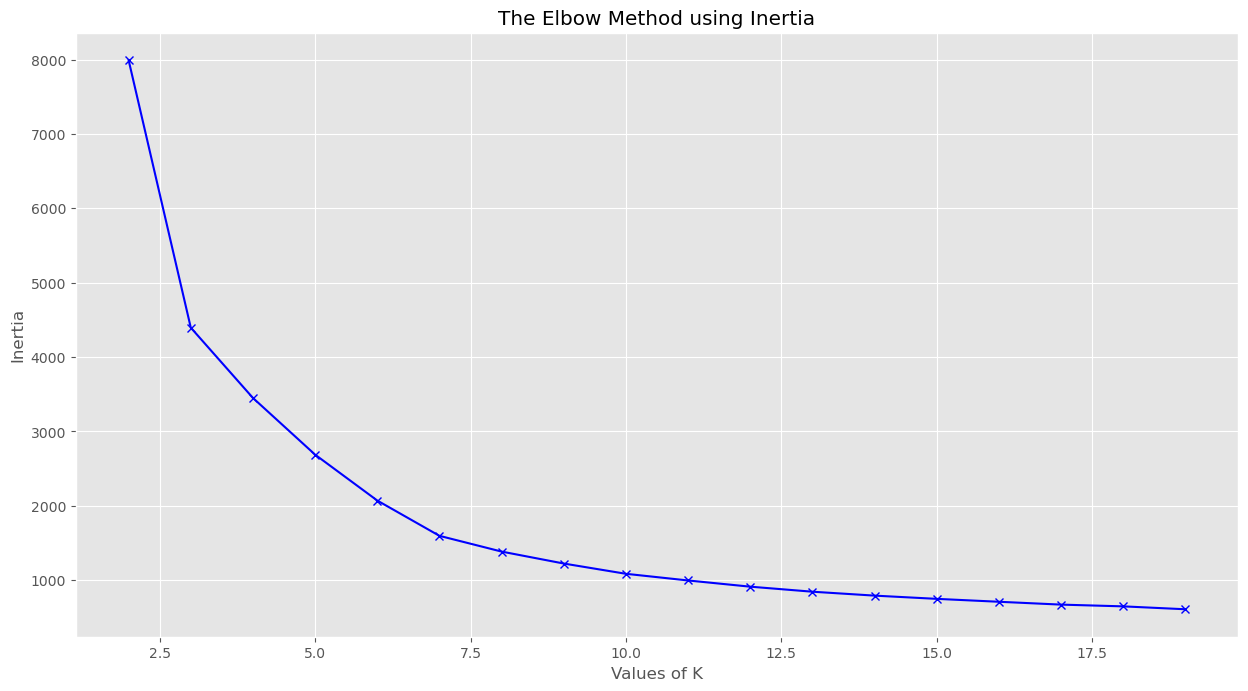

In [7]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

**k = 3 Silhouette score: 0.8014842721674662**

In [8]:
km_3 = KMeans(n_clusters=3, max_iter=300, random_state = 1234)
km_3.fit(pv_out)

KMeans(n_clusters=3, random_state=1234)

In [9]:
ph_cluster_3 = ph.copy()
ph_cluster_3['Cluster'] = km_3.labels_ + 1

Text(0.5, 1.0, 'Municipality Clustered for PVOUT')

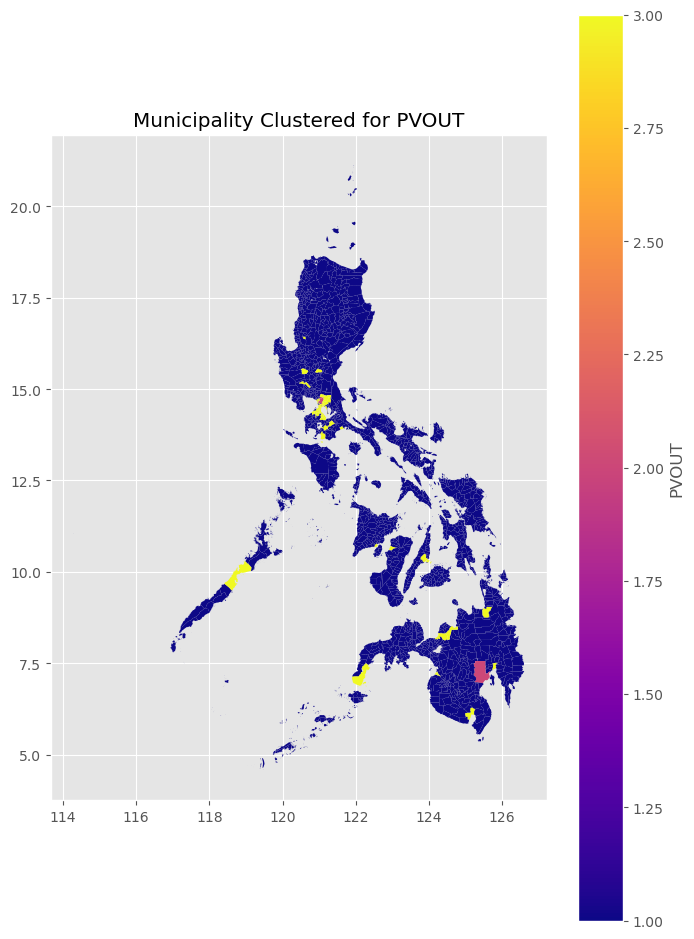

In [10]:
fig, ax = plt.subplots(figsize=(8,12))
ph_cluster_3.plot(column= 'Cluster', ax=ax, legend = True, cmap='plasma', 
             legend_kwds = {'label':'PVOUT'})
plt.title('Municipality Clustered for PVOUT')

In [11]:
ph_cluster_3.to_file(driver = 'GeoJSON', filename = "ph_clustered_3.geojson")

In [12]:
ph_cluster_3.to_file(driver = 'ESRI Shapefile', filename= "ph_clustered_3.shp")

In [13]:
pv_out_per_cluster_summary = ph_cluster_3.groupby('Cluster').agg({'PVout': ['mean', 'min', 'max','count']})
pv_out_per_cluster_summary

PVout                            
              mean        min        max count
Cluster                                       
1       1284.75950    1.46467 1738.88039  1591
2       1216.37101 1197.74269 1225.68604     3
3       1334.73807 1085.20238 1662.75058    53

In [14]:
lit_per_cluster_summary = ph_cluster_3.groupby('Cluster').agg({'lit_per': ['mean', 'min', 'max','count']})
lit_per_cluster_summary

lit_per                         
            mean      min       max count
Cluster                                  
1       44.57851  0.00789 100.00000  1591
2       95.92986 87.78958 100.00000     3
3       75.22122  0.78391 100.00000    53

In [15]:
pop_per_cluster_summary = ph_cluster_3.groupby('Cluster').agg({'Population': ['mean', 'min', 'max','count']})
pop_per_cluster_summary

Population                                  
                 mean           min           max count
Cluster                                                
1         43991.56014       1.00342  232318.52844  1591
2       2068709.03543 1581144.40549 3035152.33096     3
3        432505.35619  243863.63137  999713.99324    53

### GMM

In [36]:
silhouette_scores_gmm = []

K = range(2, 20)
 
for k in K:
    # Building and fitting the model    
    gmm = GaussianMixture(n_components = k)
    gmm.fit(pv_out)
    
    pred_clusters = gmm.predict(pv_out)
    silhouette = silhouette_score(pv_out,pred_clusters)
    silhouette_scores_gmm.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(k,silhouette))

Silhouette score for number of cluster(s) 2: 0.6953234934816831
Silhouette score for number of cluster(s) 3: 0.6642898519438726
Silhouette score for number of cluster(s) 4: 0.31923161209414563
Silhouette score for number of cluster(s) 5: 0.3168732550895538
Silhouette score for number of cluster(s) 6: 0.21597378359219482
Silhouette score for number of cluster(s) 7: 0.22410941996706485
Silhouette score for number of cluster(s) 8: 0.24823021614904187
Silhouette score for number of cluster(s) 9: 0.23654353930561833
Silhouette score for number of cluster(s) 10: 0.19493243744255576
Silhouette score for number of cluster(s) 11: 0.10485612005079324
Silhouette score for number of cluster(s) 12: 0.11465390466068823
Silhouette score for number of cluster(s) 13: 0.09194660972953254
Silhouette score for number of cluster(s) 14: 0.10960527175404766
Silhouette score for number of cluster(s) 15: 0.08837071677048752
Silhouette score for number of cluster(s) 16: 0.11307060468614336
Silhouette score for 

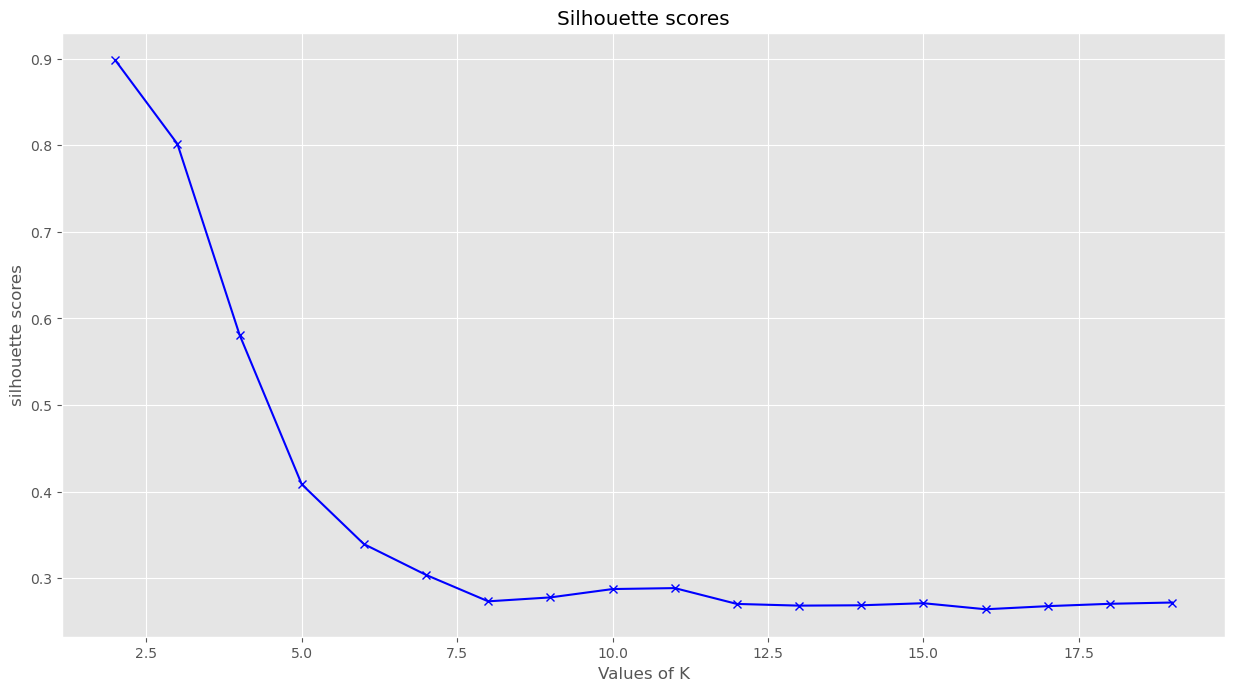

In [37]:
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('silhouette scores')
plt.title('Silhouette scores')
plt.show()

In [38]:
gmm = GaussianMixture(n_components = 3)
gmm.fit(pv_out)

pred_clusters = gmm.predict(pv_out)
silhouette = silhouette_score(pv_out,pred_clusters)
silhouette_scores.append(silhouette)
print("Silhouette score for number of cluster(s) {}: {}".format(3,silhouette))

Silhouette score for number of cluster(s) 3: 0.6376468623091471


In [39]:
set(pred_clusters)

{0, 1, 2}

In [40]:
ph_cluster_gmm = ph.copy()
ph_cluster_gmm['Cluster'] = pred_clusters + 1

Text(0.5, 1.0, 'Municipality Clustered for PVOUT')

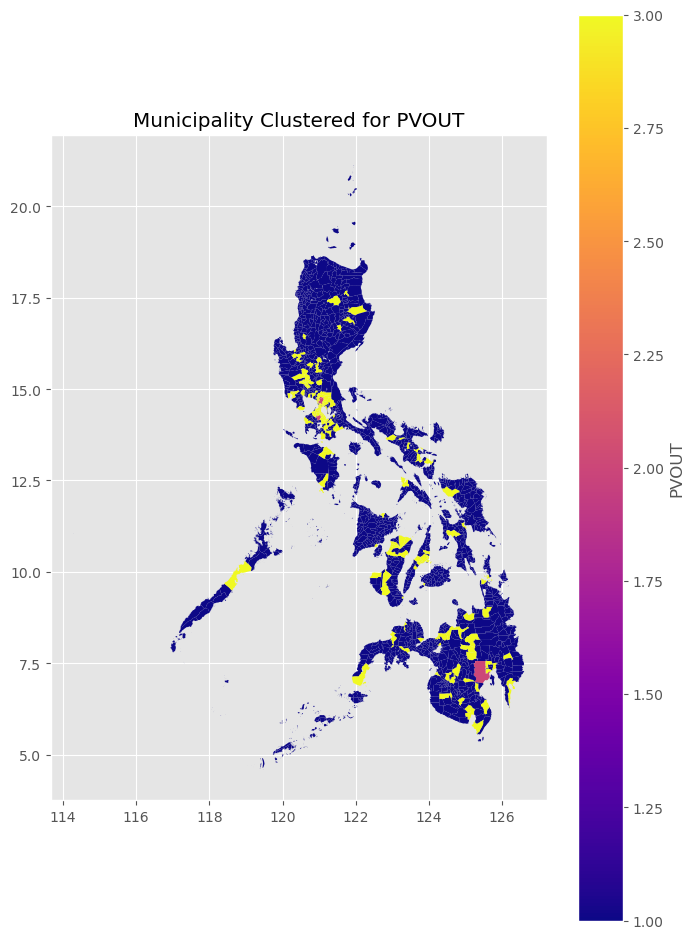

In [65]:
fig, ax = plt.subplots(figsize=(8,12))
ph_cluster_gmm.plot(column= 'Cluster', ax=ax, legend = True, cmap='plasma', 
             legend_kwds = {'label':'PVOUT'})
plt.title('Municipality Clustered for PVOUT')

In [42]:
ph_cluster_gmm.to_file(driver='GeoJSON', filename = "ph_clustered_gmm.geojson")

In [43]:
ph_cluster_gmm.to_file(driver='GeoJSON', filename = "ph_clustered_gmm.geojson")

In [46]:
pv_out_per_cluster_summary = ph_cluster_gmm.groupby('Cluster').agg({'PVout': ['mean', 'min', 'max','count']})
pv_out_per_cluster_summary

PVout                            
              mean        min        max count
Cluster                                       
1       1282.94442    1.46467 1738.88039  1479
2       1225.24707 1197.74269 1251.87527     4
3       1317.48051 1024.17264 1666.00691   164

In [47]:
lit_per_cluster_summary = ph_cluster_gmm.groupby('Cluster').agg({'lit_per': ['mean', 'min', 'max','count']})
lit_per_cluster_summary

lit_per                         
            mean      min       max count
Cluster                                  
1       42.98949  0.00789 100.00000  1479
2       96.94184 87.78958 100.00000     4
3       68.47380  0.78391 100.00000   164

In [48]:
pop_per_cluster_summary = ph_cluster_gmm.groupby('Cluster').agg({'Population': ['mean', 'min', 'max','count']})
pop_per_cluster_summary

Population                                 
                 mean          min           max count
Cluster                                               
1         36251.44976      1.00342  115520.66538  1479
2       1609611.40869 232318.52844 3035152.33096     4
3        238202.09352 103595.98256  999713.99324   164

### DBScan

In [52]:
neighbors = NearestNeighbors(n_neighbors = 20)
neighbors_fit = neighbors.fit(pv_out)
distances, indices = neighbors_fit.kneighbors(pv_out)

**Knee Plot**

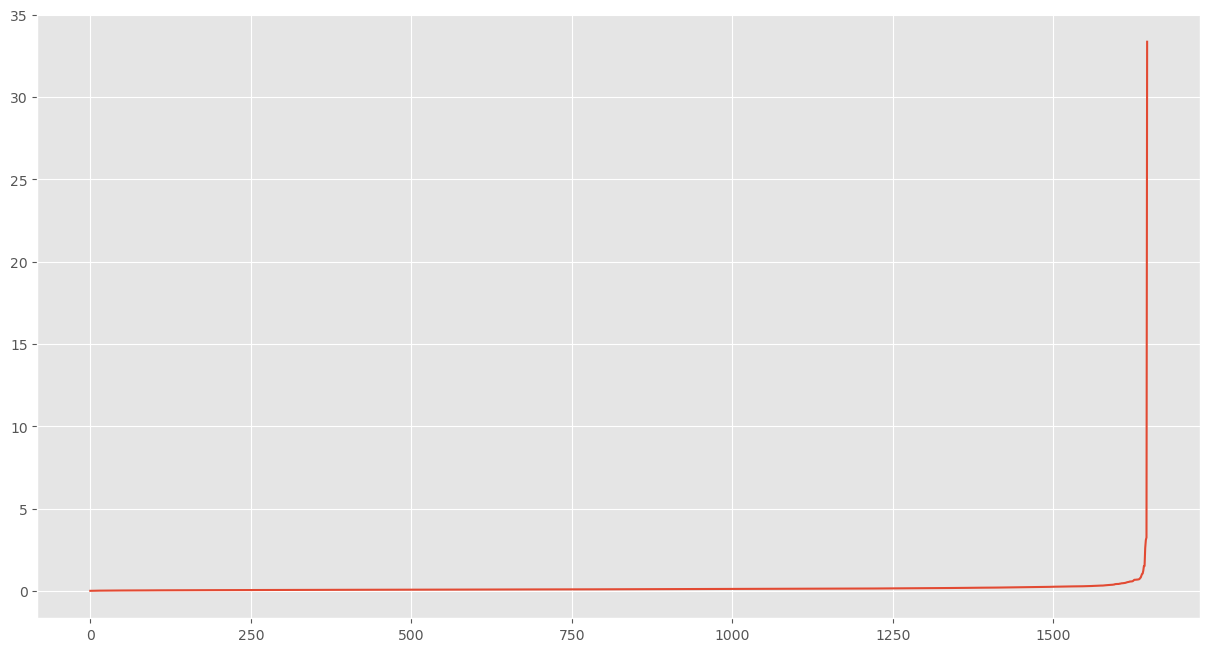

In [53]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [54]:
print("Number of distances from Knee plot is : {}".format(len(distances)))

Number of distances from Knee plot is : 1647


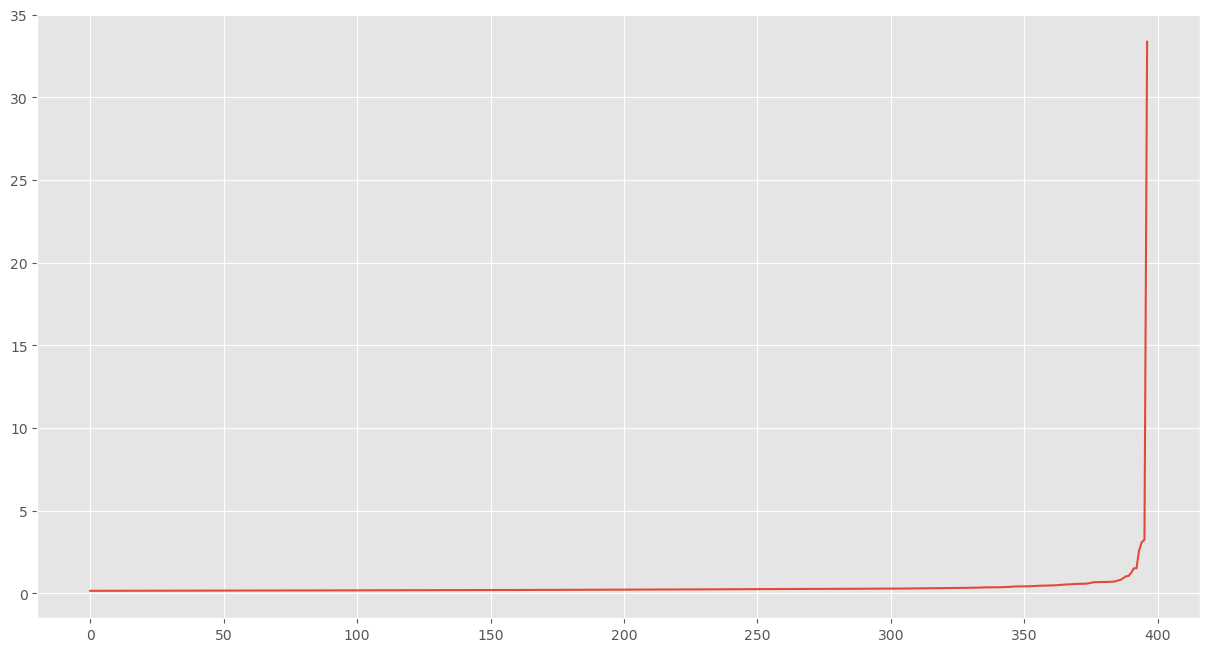

In [55]:
distances = distances[1250:1647]
plt.plot(distances)

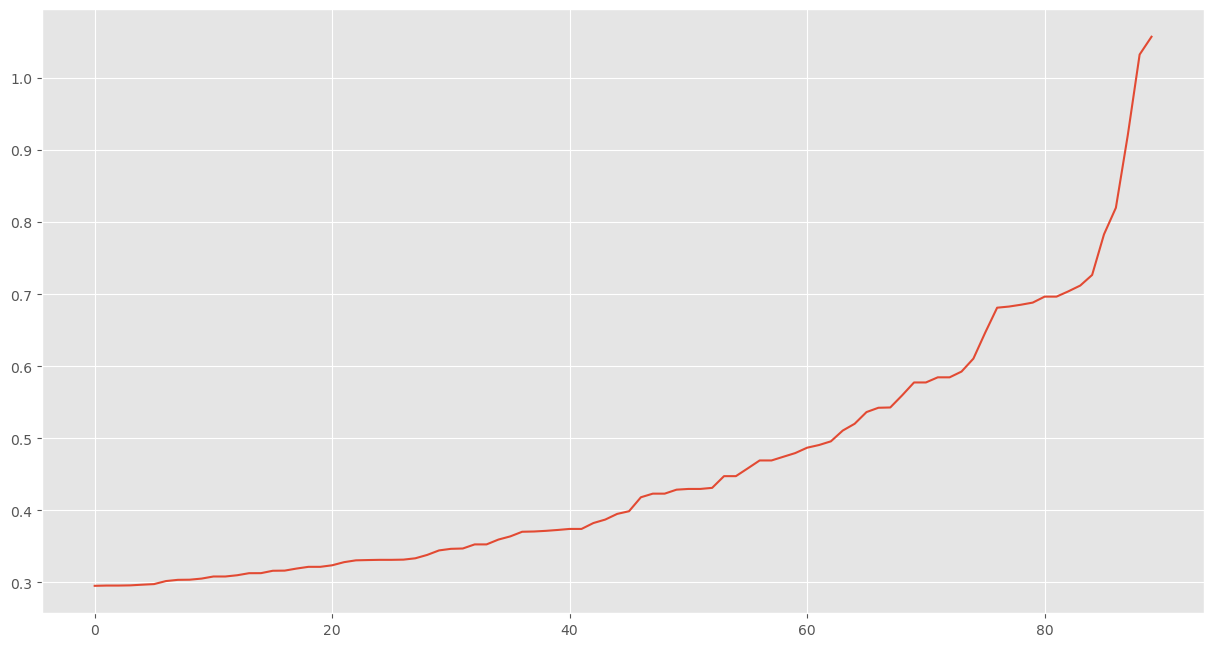

In [56]:
distances = distances[300:390]
plt.plot(distances)

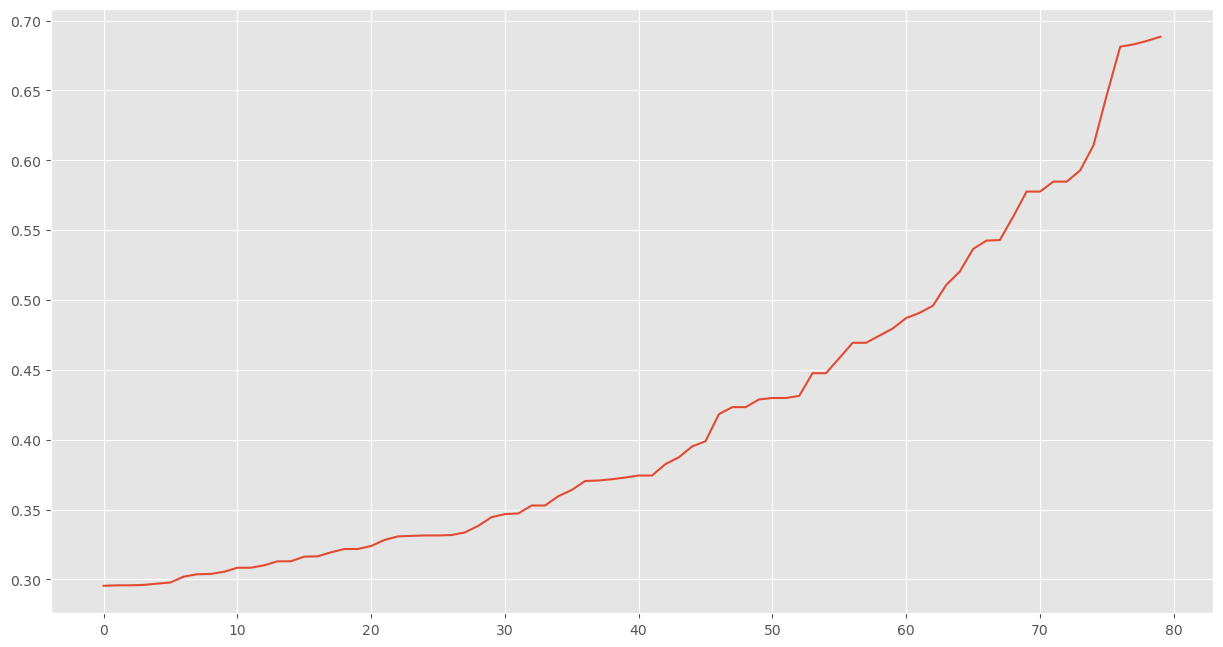

In [70]:
distances = distances[0:80]
plt.plot(distances)

In [71]:
len(distances)

80

In [72]:
silhouette_scores_dbscan = []

for eps in distances:
    
    # Building and fitting the model
    db = DBSCAN(eps = eps, min_samples = 20)
    db.fit(pv_out)
    
    pred_clusters = db.labels_
    n_clusters    = len(set(pred_clusters))
    if n_clusters > 1:
        silhouette_dbscan = silhouette_score(pv_out,pred_clusters)
        silhouette_scores_dbscan.append(silhouette_dbscan)
        print("Silhouette score for eps {} with number of cluster(s) {}: {}".format(eps, n_clusters, silhouette_dbscan))
        
    else:
        print("No Silhouette score for eps {} with number of cluster(s) {}".format(eps, n_clusters))

Silhouette score for eps 0.2953570011790664 with number of cluster(s) 2: 0.224254627729477
Silhouette score for eps 0.2957237123888802 with number of cluster(s) 2: 0.2247369161888374
Silhouette score for eps 0.2957237123888802 with number of cluster(s) 2: 0.2247369161888374
Silhouette score for eps 0.295998138985817 with number of cluster(s) 2: 0.2247369161888374
Silhouette score for eps 0.2969365184905846 with number of cluster(s) 3: 0.07734771265499017
Silhouette score for eps 0.2977545721210957 with number of cluster(s) 3: 0.0861183492509105
Silhouette score for eps 0.30195924356282505 with number of cluster(s) 2: 0.250209160437834
Silhouette score for eps 0.30365202478845266 with number of cluster(s) 2: 0.252900530147643
Silhouette score for eps 0.30385413040032566 with number of cluster(s) 2: 0.252900530147643
Silhouette score for eps 0.30539581273899497 with number of cluster(s) 3: 0.014636306634356005
Silhouette score for eps 0.308299943216455 with number of cluster(s) 2: 0.2726

In [73]:
 np.max(silhouette_scores_dbscan)

0.762032509127361

In [74]:
eps_optimal = distances[np.argmax(silhouette_scores_dbscan, axis=0)]
print("Optimal eps for Silhouette score of {}: {}".format(np.max(silhouette_scores_dbscan), eps_optimal))

Optimal eps for Silhouette score of 0.762032509127361: 0.6884760084414351


In [75]:
dbscan = DBSCAN(eps = eps_optimal, min_samples = 20)
dbscan.fit(pv_out)

pred_clusters = dbscan.labels_
n_clusters    = len(set(pred_clusters))

silhouette = silhouette_score(pv_out,pred_clusters)
silhouette_scores.append(silhouette)
print("Silhouette score for eps {} with number of cluster(s) {}: {}".format(eps, n_clusters, silhouette))

Silhouette score for eps 0.6884760084414351 with number of cluster(s) 2: 0.762032509127361


In [76]:
set(pred_clusters)

{-1, 0}

In [77]:
ph_cluster_dbscan = ph.copy()
ph_cluster_dbscan['Cluster'] = pred_clusters + 2

Text(0.5, 1.0, 'Municipality Clustered for PVOUT')

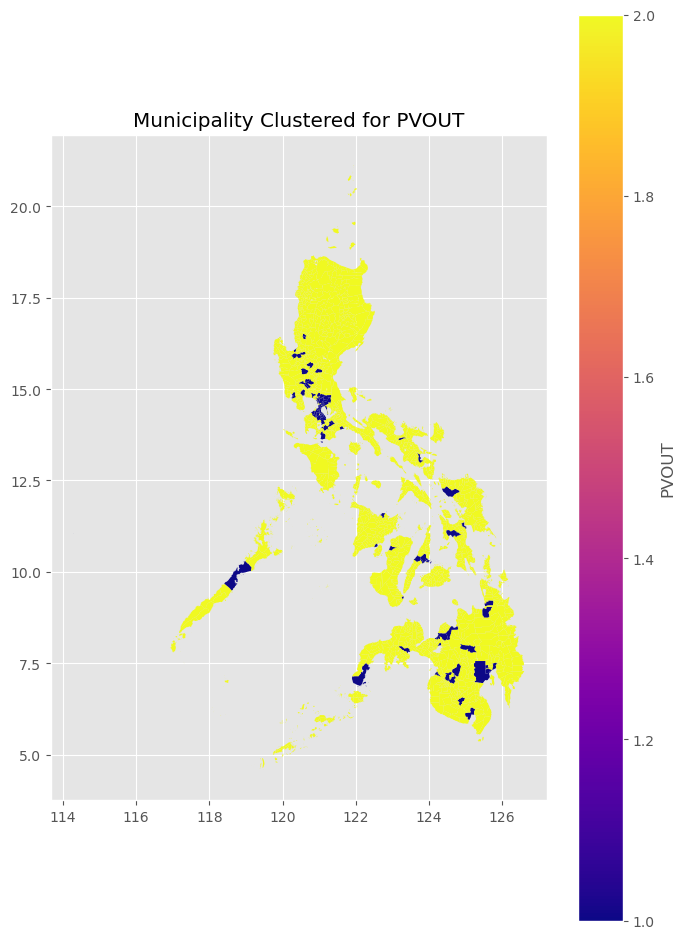

In [78]:
fig, ax = plt.subplots(figsize=(8,12))
ph_cluster_dbscan.plot(column= 'Cluster', ax=ax, legend = True, cmap='plasma', 
             legend_kwds = {'label':'PVOUT'})
plt.title('Municipality Clustered for PVOUT')

In [79]:
ph_cluster_dbscan.to_file(driver = 'GeoJSON', filename = "ph_clustered_dbscan.geojson")

In [80]:
ph_cluster_dbscan.to_file(driver = 'ESRI Shapefile', filename= "ph_clustered_dbscan.shp")

In [81]:
pv_out_per_cluster_summary = ph_cluster_dbscan.groupby('Cluster').agg({'PVout': ['mean', 'min', 'max','count']})
pv_out_per_cluster_summary

PVout                           
              mean       min        max count
Cluster                                      
1       1330.27913   1.46467 1666.00691    94
2       1283.57782 712.12272 1738.88039  1553

In [82]:
lit_per_cluster_summary = ph_cluster_dbscan.groupby('Cluster').agg({'lit_per': ['mean', 'min', 'max','count']})
lit_per_cluster_summary

lit_per                        
            mean     min       max count
Cluster                                 
1       70.60219 0.78391 100.00000    94
2       44.14831 0.00789 100.00000  1553

In [83]:
pop_per_cluster_summary = ph_cluster_dbscan.groupby('Cluster').agg({'Population': ['mean', 'min', 'max','count']})
pop_per_cluster_summary

Population                            
                mean     min           max count
Cluster                                         
1       379602.09991 1.46467 3035152.33096    94
2        40847.96251 1.00342  167010.17462  1553

## Comparison of Silhouette Scores 

|**Model**|**Silhouette Scores**|**Number of Clusters**|
|:-|------|------|
|K Means Clustering Model  |0.801484     |3     |
|GMM     |0.637646    |3     |
|DBScan     |0.762032     |2     |

The model with the highest silhouette score is the K-Means with 3 groups. Therefore, the data for the municipalities will be clustered into 3 total groups, having cluster 3 representing the municipalities with coverage for average populated areas but more than 50% mean lit per area.

In [84]:
pv_out_per_cluster_summary

PVout                           
              mean       min        max count
Cluster                                      
1       1330.27913   1.46467 1666.00691    94
2       1283.57782 712.12272 1738.88039  1553

In [85]:
lit_per_cluster_summary

lit_per                        
            mean     min       max count
Cluster                                 
1       70.60219 0.78391 100.00000    94
2       44.14831 0.00789 100.00000  1553

In [86]:
pop_per_cluster_summary

Population                            
                mean     min           max count
Cluster                                         
1       379602.09991 1.46467 3035152.33096    94
2        40847.96251 1.00342  167010.17462  1553

## PVOut value used is direct data from the World Bank 

### Preparation of Data for Training Clustering Models

In [87]:
ph_worldbank = gpd.read_file('data/integrated_data_worldbank_pvout.geojson')
ph_worldbank.head()

,ADM3_EN,ADM3_PCODE,ADM3ALT1EN,ADM2_EN,ADM1_EN,ADM0_EN,mean,total_area,nolit_per,lit_per,GHI,TEMP,PVout,Population,geometry
0,Panglima Sugala,PH157001000,Balimbing,Tawi-Tawi,Autonomous Region in Muslim Mindanao,Philippines (the),0.83074,1.90237,84.33204,15.66796,1768.75519,26.73646,1295.12970,20542.15473,"MULTIPOLYGON (((119.93158 4.90053, 119.93167 4..."
1,Bongao,PH157002000,Capital,Tawi-Tawi,Autonomous Region in Muslim Mindanao,Philippines (the),2.65462,3.16960,26.21539,73.78461,1772.73741,26.96528,1304.74025,52269.20889,"MULTIPOLYGON (((119.76332 5.01178, 119.76282 5..."
2,Mapun,PH157003000,Cagayan de Tawi-Tawi,Tawi-Tawi,Autonomous Region in Muslim Mindanao,Philippines (the),0.55466,1.31950,78.15337,21.84663,1798.93121,26.72738,1339.54399,16606.52010,"MULTIPOLYGON (((118.40042 6.87783, 118.40052 6..."
3,Simunul,PH157004000,None,Tawi-Tawi,Autonomous Region in Muslim Mindanao,Philippines (the),0.75363,1.10777,16.71362,83.28638,1859.88090,27.08906,1438.41764,25882.47008,"MULTIPOLYGON (((119.84475 4.81262, 119.84490 4..."
4,Sitangkai,PH157005000,None,Tawi-Tawi,Autonomous Region in Muslim Mindanao,Philippines (the),1.30635,0.84159,34.51110,65.48890,1830.44474,27.09429,1393.33850,6919.10005,"MULTIPOLYGON (((119.38935 4.61459, 119.38918 4..."


In [88]:
nan_index = ph_worldbank.index[ph_worldbank.PVout.isnull()].values
# Impute PV Out based on Location
for index in nan_index:
    loc_name = ph_worldbank.loc[index,"ADM2_EN"]
    imputed_value = ph_worldbank[ph_worldbank['ADM2_EN'] == loc_name].mean().values[0]
    ph_worldbank.loc[index,'PVout'] = imputed_value
    
nan_index = ph_worldbank.index[ph_worldbank.nolit_per.isnull()].values
# Impute No Lit based on Location
for index in nan_index:
    loc_name = ph_worldbank.loc[index,"ADM1_EN"]
    if loc_name == 'National Capital Region':
        imputed_value = 0 # Min Lit for NCR
    else:
        imputed_value = ph_worldbank[ph_worldbank['ADM1_EN'] == loc_name].mean().values[0]
    ph_worldbank.loc[index,'nolit_per'] = imputed_value
    
nan_index = ph_worldbank.index[ph_worldbank.lit_per.isnull()].values
# Impute Lit based on Location
for index in nan_index:
    loc_name = ph_worldbank.loc[index,"ADM1_EN"]
    if loc_name == 'National Capital Region':
        imputed_value = 100 # Max Lit
    else:
        imputed_value = ph_worldbank[ph_worldbank['ADM1_EN'] == loc_name].mean().values[0]

    ph_worldbank.loc[index,'lit_per'] = imputed_value
    
nan_index = ph_worldbank.index[ph_worldbank.Population.isnull()].values
# Impute Population based on Location
for index in nan_index:
    loc_name = ph_worldbank.loc[index,"ADM2_EN"]
    imputed_value = ph_worldbank[ph_worldbank['ADM2_EN'] == loc_name].mean().values[0]
    ph_worldbank.loc[index,'Population'] = imputed_value

In [89]:
wb_pv_out = ph_worldbank[['lit_per','PVout','Population']]
wb_pv_out = wb_pv_out.to_numpy()
scaler = RobustScaler()
pv_out= scaler.fit_transform(wb_pv_out)
print(wb_pv_out.shape)

(1647, 3)


### KMeans Clustering Model 

In [91]:
distortions = []
distortion_map = {}

inertias = []
inertia_map = {}

silhouette_scores = []

K = range(2, 20)
 
for k in K:
    # Building and fitting the model
    kmeans = KMeans(n_clusters = k, max_iter=300, random_state = 1234)
    kmeans.fit(wb_pv_out)
    
    # Distortions 
    distortions.append(sum(np.min(cdist(wb_pv_out, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / wb_pv_out.shape[0])
    distortion_map[k] = sum(np.min(cdist(wb_pv_out, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / wb_pv_out.shape[0]
    
    # Inertia
    inertias.append(kmeans.inertia_)
    inertia_map[k] = kmeans.inertia_
    
    pred_clusters = kmeans.predict(wb_pv_out)
    silhouette = silhouette_score(wb_pv_out,pred_clusters)
    silhouette_scores.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(k,silhouette))

Silhouette score for number of cluster(s) 2: 0.928871258505822
Silhouette score for number of cluster(s) 3: 0.8810466273239878
Silhouette score for number of cluster(s) 4: 0.799005283655246
Silhouette score for number of cluster(s) 5: 0.7635913033646017
Silhouette score for number of cluster(s) 6: 0.6648985178067628
Silhouette score for number of cluster(s) 7: 0.6091080459140841
Silhouette score for number of cluster(s) 8: 0.5946638181263253
Silhouette score for number of cluster(s) 9: 0.5725988293371836
Silhouette score for number of cluster(s) 10: 0.5735210116561102
Silhouette score for number of cluster(s) 11: 0.5656552921536572
Silhouette score for number of cluster(s) 12: 0.5513381935755863
Silhouette score for number of cluster(s) 13: 0.5471157524458421
Silhouette score for number of cluster(s) 14: 0.5455586366535822
Silhouette score for number of cluster(s) 15: 0.5496876815173337
Silhouette score for number of cluster(s) 16: 0.5382582670349408
Silhouette score for number of clus

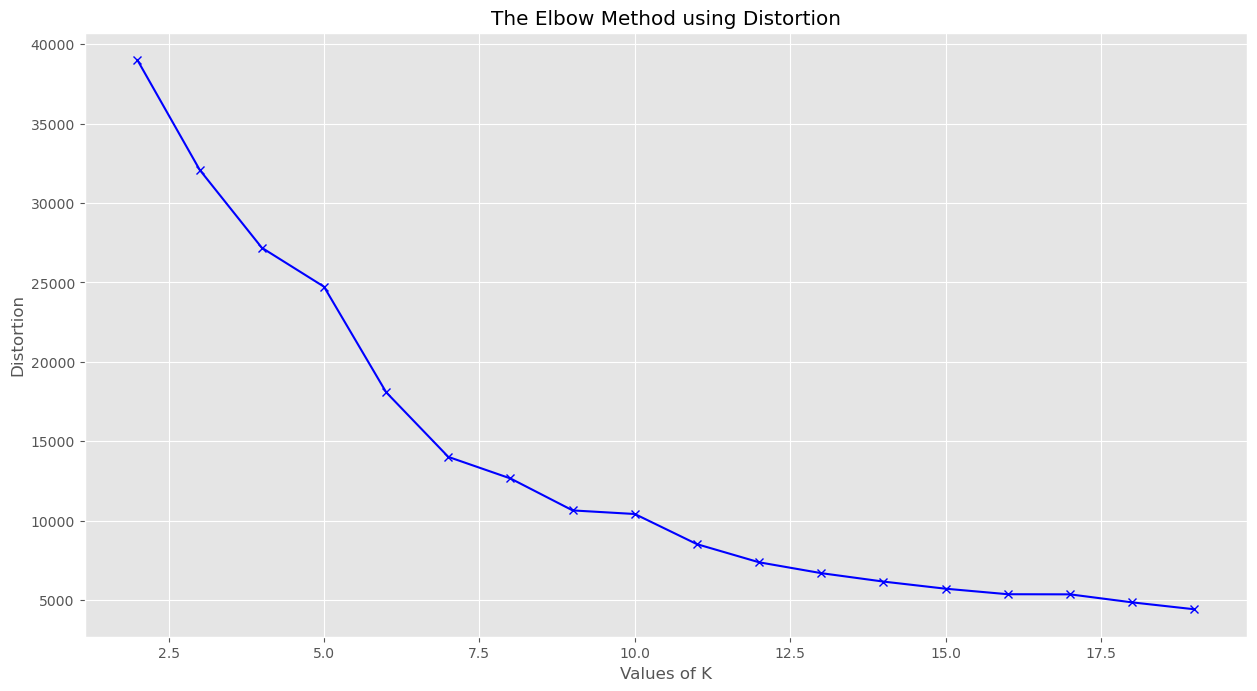

In [103]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

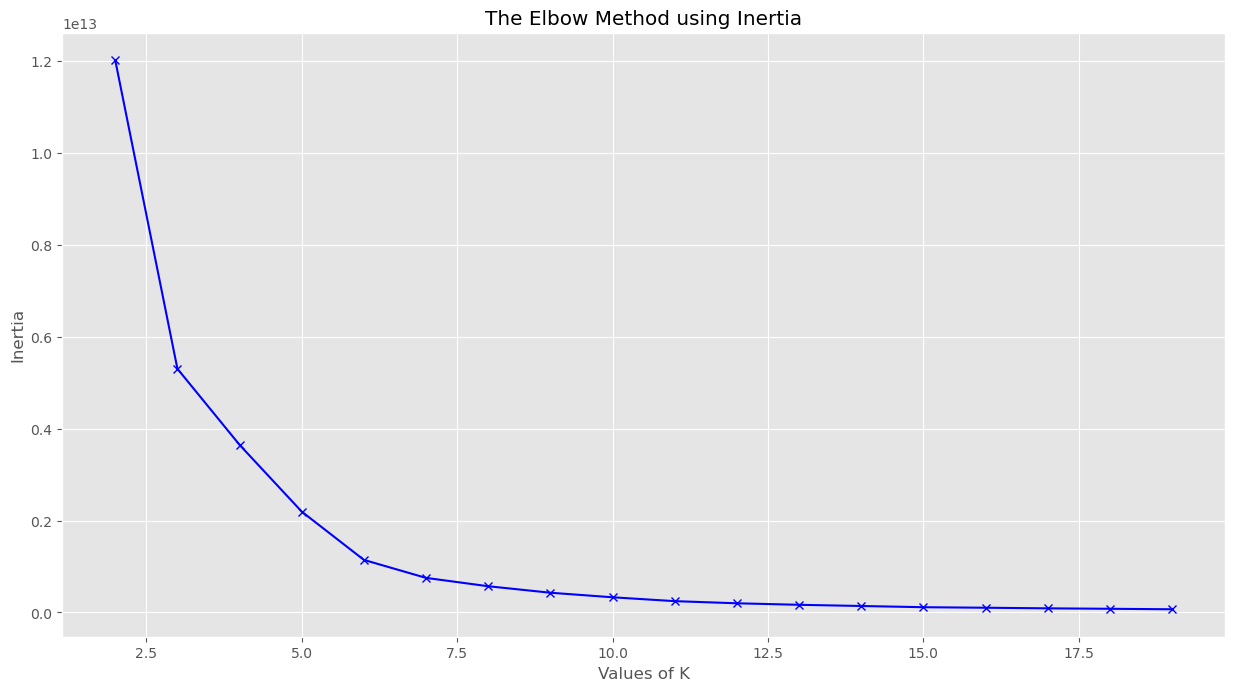

In [104]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

**k= 5 Silhouette score: 0.7635913033646017**

In [94]:
km_5 = KMeans(n_clusters=5, max_iter=300, random_state = 1234)
km_5.fit(wb_pv_out)

KMeans(n_clusters=5, random_state=1234)

In [109]:
ph_cluster_5 = ph_worldbank.copy()
ph_cluster_5['Cluster'] = km_5.labels_ + 1

Text(0.5, 1.0, 'Municipality Clustered for PVOUT(WorldBank Data)')

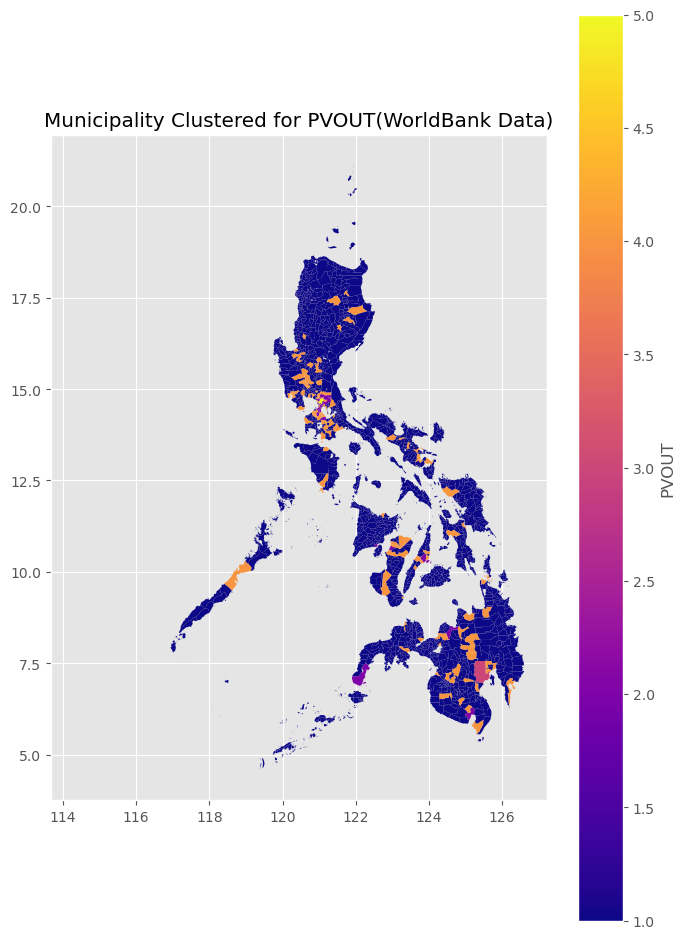

In [110]:
fig, ax = plt.subplots(figsize=(8,12))
ph_cluster_5.plot(column= 'Cluster', ax=ax, legend = True, cmap='plasma', 
             legend_kwds = {'label':'PVOUT'})
plt.title('Municipality Clustered for PVOUT(WorldBank Data)')

In [111]:
ph_cluster_5.to_file(driver='GeoJSON', filename = "ph_clustered_5.geojson")

In [112]:
ph_cluster_5.to_file(driver = 'ESRI Shapefile', filename= "ph_clustered_5.shp")

In [113]:
wb_pv_out_per_cluster_summary = ph_cluster_5.groupby('Cluster').agg({'PVout': ['mean', 'min', 'max','count']})
wb_pv_out_per_cluster_summary

PVout                            
              mean        min        max count
Cluster                                       
1       1282.14558    1.46467 1738.88039  1490
2       1324.67570 1085.20238 1531.80941    23
3       1225.68516 1225.68428 1225.68604     2
4       1327.70240 1024.17264 1674.55789   131
5       1197.74269 1197.74269 1197.74269     1

In [114]:
wb_lit_per_cluster_summary = ph_cluster_5.groupby('Cluster').agg({'lit_per': ['mean', 'min', 'max','count']})
wb_lit_per_cluster_summary

lit_per                          
             mean       min       max count
Cluster                                    
1        42.90733   0.00789 100.00000  1490
2        81.24607   1.29575 100.00000    23
3        93.89479  87.78958 100.00000     2
4        69.54622   0.78391 100.00000   131
5       100.00000 100.00000 100.00000     1

In [115]:
wb_pop_per_cluster_summary = ph_cluster_5.groupby('Cluster').agg({'Population': ['mean', 'min', 'max','count']})
wb_pop_per_cluster_summary

Population                                  
                 mean           min           max count
Cluster                                                
1         36769.93644       1.00342  111122.08157  1490
2        594049.49939  406391.84561  999713.99324    23
3       1585487.38767 1581144.40549 1589830.36985     2
4        186740.55169  112104.49911  381723.44669   131
5       3035152.33096 3035152.33096 3035152.33096     1

### GMM

In [105]:
silhouette_scores_gmm = []

K = range(2, 20)
 
for k in K:
    # Building and fitting the model    
    gmm = GaussianMixture(n_components = k)
    gmm.fit(wb_pv_out)
    
    pred_clusters = gmm.predict(wb_pv_out)
    silhouette = silhouette_score(wb_pv_out,pred_clusters)
    silhouette_scores_gmm.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(k,silhouette))

Silhouette score for number of cluster(s) 2: 0.8067353060229371
Silhouette score for number of cluster(s) 3: 0.7908935656009931
Silhouette score for number of cluster(s) 4: 0.6278164318888698
Silhouette score for number of cluster(s) 5: 0.6294749461920894
Silhouette score for number of cluster(s) 6: 0.622526544622028
Silhouette score for number of cluster(s) 7: 0.5919016882291783
Silhouette score for number of cluster(s) 8: 0.429639919554022
Silhouette score for number of cluster(s) 9: 0.24099236318119407
Silhouette score for number of cluster(s) 10: 0.14247618032643583
Silhouette score for number of cluster(s) 11: 0.31768634338708307
Silhouette score for number of cluster(s) 12: 0.47282244016423525
Silhouette score for number of cluster(s) 13: 0.5245325424902952
Silhouette score for number of cluster(s) 14: 0.5226955085368263
Silhouette score for number of cluster(s) 15: 0.44457416682458606
Silhouette score for number of cluster(s) 16: 0.46786026955328786
Silhouette score for number o

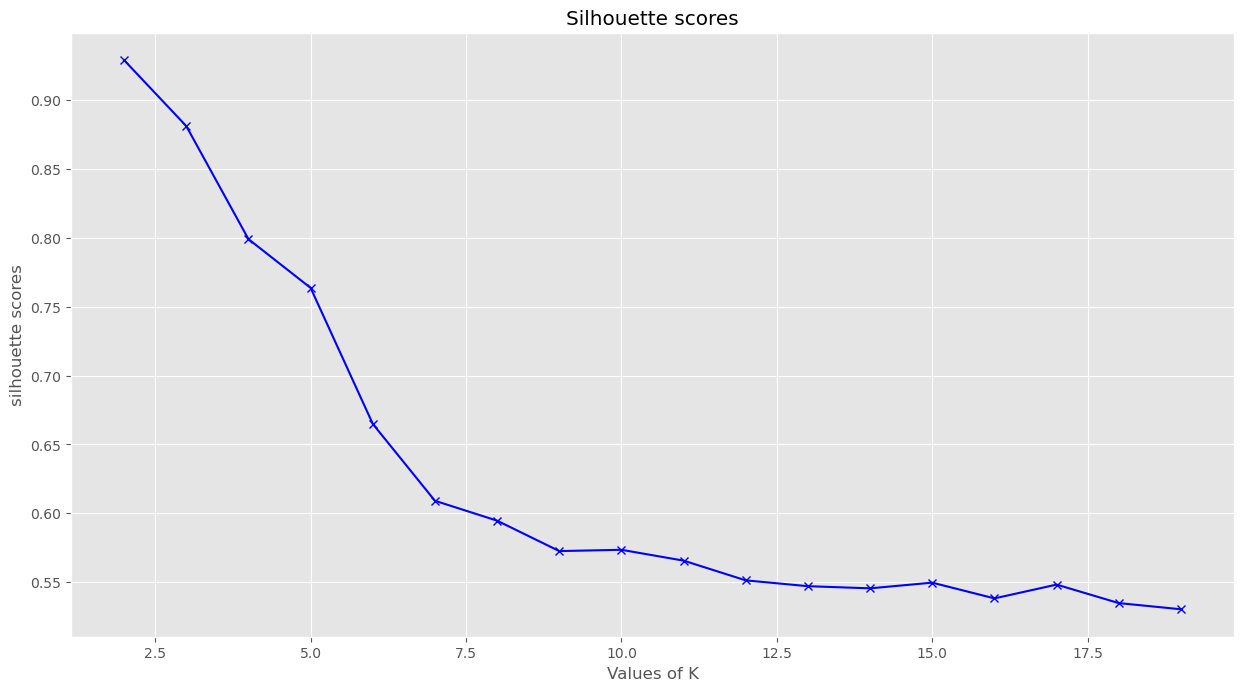

In [106]:
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('silhouette scores')
plt.title('Silhouette scores')
plt.show()

In [107]:
gmm = GaussianMixture(n_components = 5)
gmm.fit(wb_pv_out)

pred_clusters = gmm.predict(wb_pv_out)
silhouette = silhouette_score(wb_pv_out,pred_clusters)
silhouette_scores.append(silhouette)
print("Silhouette score for number of cluster(s) {}: {}".format(5,silhouette))

Silhouette score for number of cluster(s) 5: 0.6281769863672978


In [108]:
set(pred_clusters)

{0, 1, 2, 3, 4}

In [116]:
wb_ph_cluster_gmm = ph_worldbank.copy()
wb_ph_cluster_gmm['Cluster'] = pred_clusters + 1

Text(0.5, 1.0, 'Municipality Clustered for PVOUT (WorldBank Data)')

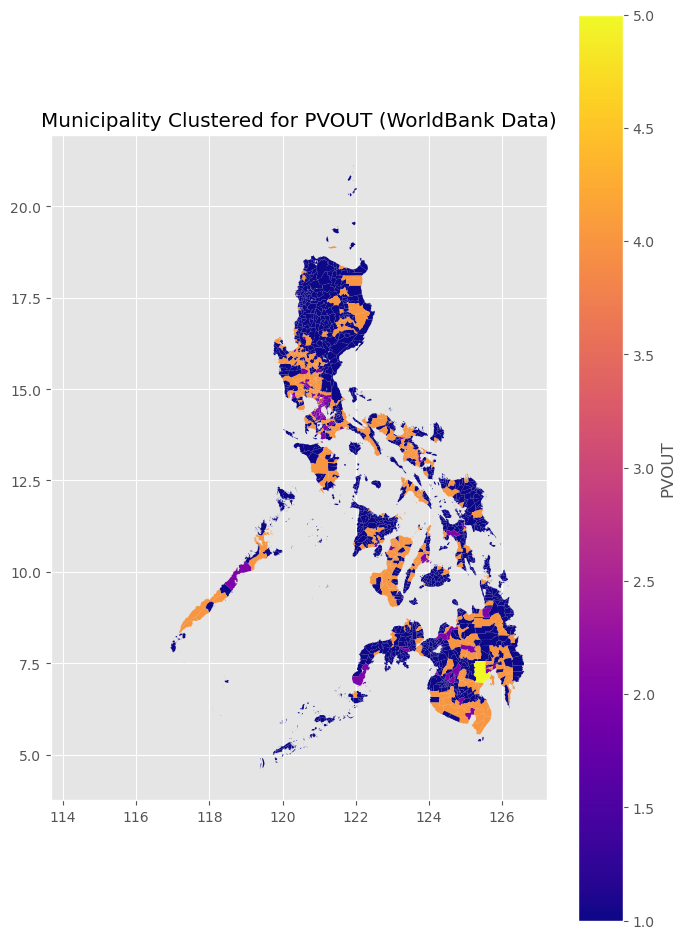

In [117]:
fig, ax = plt.subplots(figsize=(8,12))
wb_ph_cluster_gmm.plot(column= 'Cluster', ax=ax, legend = True, cmap='plasma', 
             legend_kwds = {'label':'PVOUT'})
plt.title('Municipality Clustered for PVOUT (WorldBank Data)')

In [119]:
wb_ph_cluster_gmm.to_file(driver='GeoJSON', filename = "ph_clustered_gmm_5.geojson")

In [24]:
wb_ph_cluster_gmm.to_file(driver='GeoJSON', filename = "ph_clustered_gmm_5.geojson")

In [121]:
wb_pv_out_per_cluster_summary = wb_ph_cluster_gmm.groupby('Cluster').agg({'PVout': ['mean', 'min', 'max','count']})
wb_pv_out_per_cluster_summary

PVout                            
              mean        min        max count
Cluster                                       
1       1274.79086    1.46467 1738.88039  1201
2       1343.86396 1024.17264 1662.75058    78
3       1197.74269 1197.74269 1197.74269     1
4       1312.18703  897.19561 1729.06336   365
5       1225.68516 1225.68428 1225.68604     2

In [123]:
wb_lit_per_cluster_summary = wb_ph_cluster_gmm.groupby('Cluster').agg({'lit_per': ['mean', 'min', 'max','count']})
wb_lit_per_cluster_summary

lit_per                          
             mean       min       max count
Cluster                                    
1        39.36984   0.00789 100.00000  1201
2        68.11241   0.78391 100.00000    78
3       100.00000 100.00000 100.00000     1
4        61.13751   1.93444 100.00000   365
5        93.89479  87.78958 100.00000     2

In [124]:
wb_pop_per_cluster_summary = wb_ph_cluster_gmm.groupby('Cluster').agg({'Population': ['mean', 'min', 'max','count']})
wb_pop_per_cluster_summary

Population                                  
                 mean           min           max count
Cluster                                                
1         26909.80018       1.00342   60381.34609  1201
2        353789.44228  119229.61057  999713.99324    78
3       3035152.33096 3035152.33096 3035152.33096     1
4         90408.51929   52701.89496  189963.57511   365
5       1585487.38767 1581144.40549 1589830.36985     2

### DBScan

In [133]:
neighbors = NearestNeighbors(n_neighbors = 20)
neighbors_fit = neighbors.fit(wb_pv_out)
distances, indices = neighbors_fit.kneighbors(pv_out)

### Knee Plot

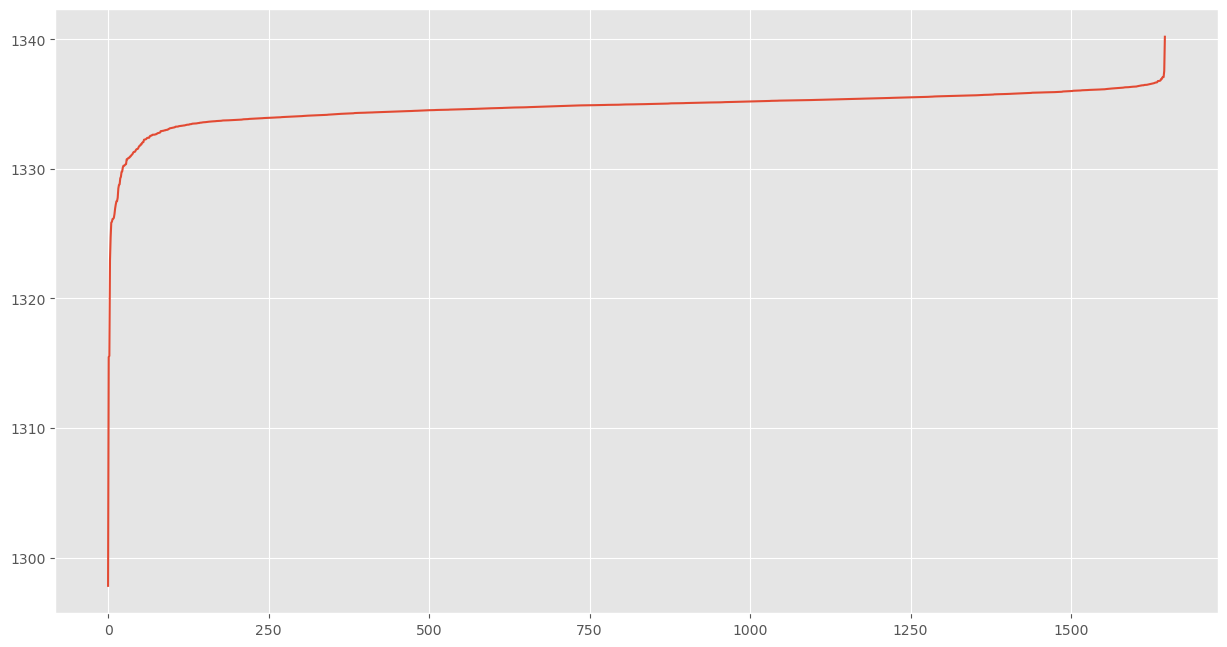

In [134]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [135]:
print("Number of distances from Knee plot is : {}".format(len(distances)))

Number of distances from Knee plot is : 1647


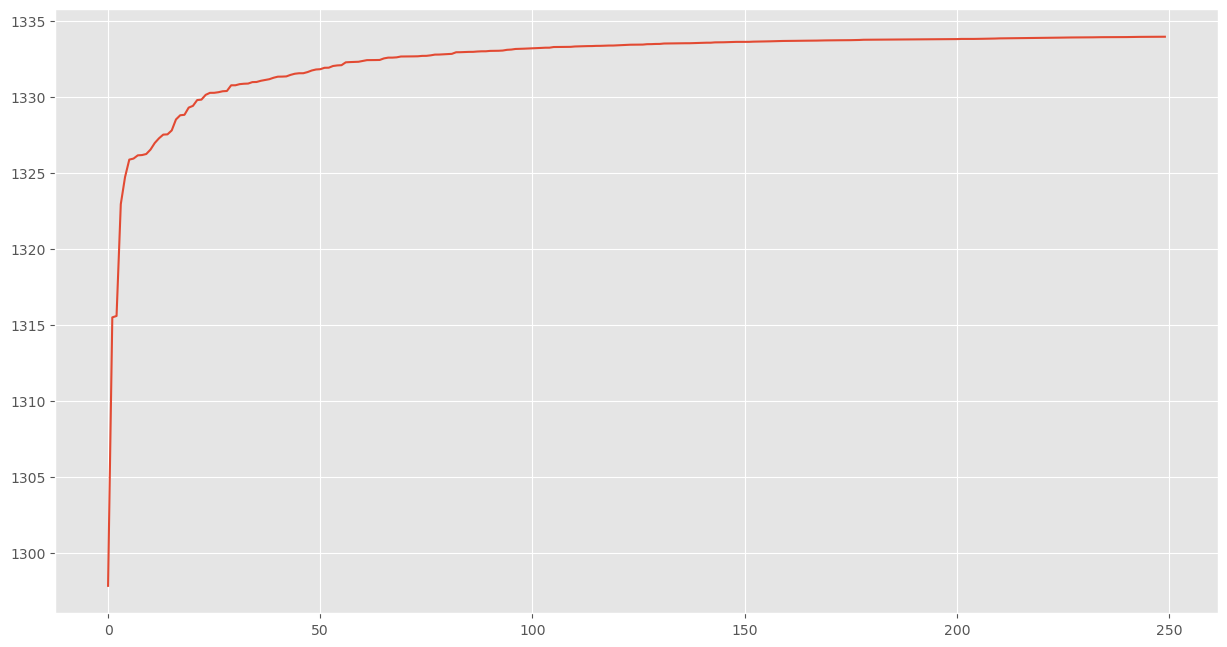

In [136]:
distances = distances[0:250]
plt.plot(distances)

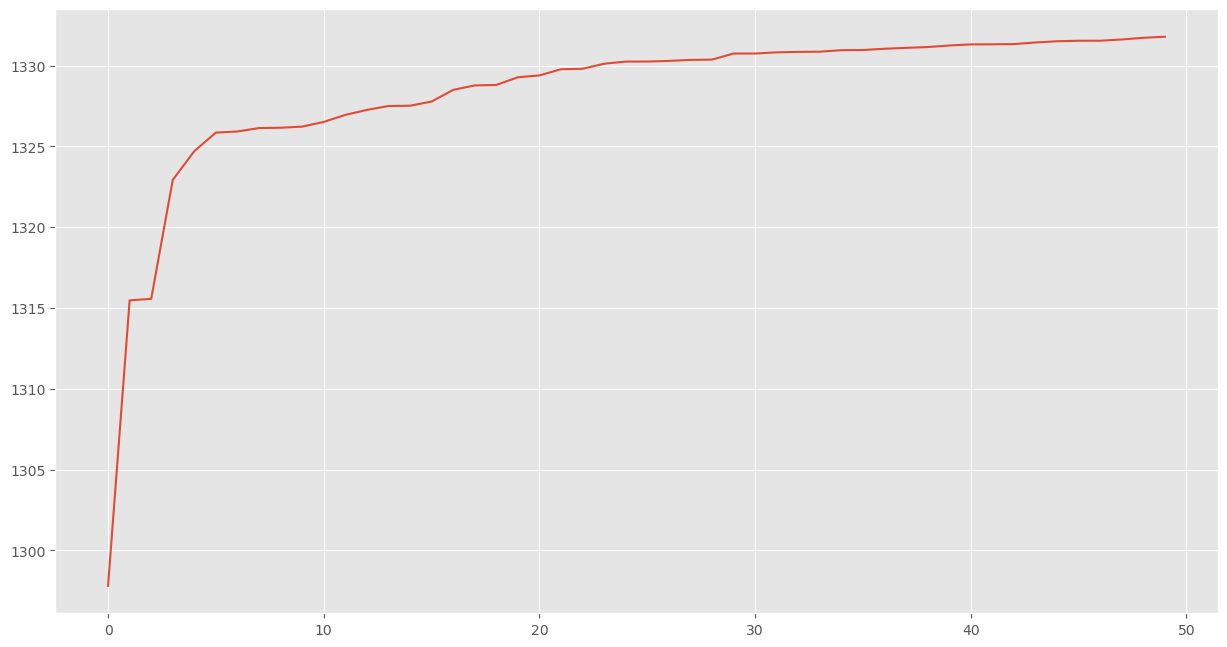

In [137]:
distances = distances[0:50]
plt.plot(distances)

In [138]:
len(distances)

50

In [139]:
silhouette_scores = []

for eps in distances:
    
    # Building and fitting the model
    db = DBSCAN(eps = eps, min_samples = 20)
    db.fit(wb_pv_out)
    
    pred_clusters = db.labels_
    n_clusters    = len(set(pred_clusters))
    if n_clusters > 1:
        silhouette = silhouette_score(pv_out,pred_clusters)
        silhouette_scores.append(silhouette)
        print("Silhouette score for eps {} with number of cluster(s) {}: {}".format(eps, n_clusters, silhouette))
        
    else:
        print("No Silhouette score for eps {} with number of cluster(s) {}".format(eps, n_clusters))

Silhouette score for eps 1297.814896277203 with number of cluster(s) 3: 0.08573427309457497
Silhouette score for eps 1315.473579048626 with number of cluster(s) 3: 0.08827915286978462
Silhouette score for eps 1315.5678203223058 with number of cluster(s) 3: 0.08827915286978462
Silhouette score for eps 1322.9254413829324 with number of cluster(s) 3: 0.08827915286978462
Silhouette score for eps 1324.7055039501888 with number of cluster(s) 3: 0.08827915286978462
Silhouette score for eps 1325.8515639932616 with number of cluster(s) 4: 0.03827385753224852
Silhouette score for eps 1325.9205927061703 with number of cluster(s) 4: 0.03827385753224852
Silhouette score for eps 1326.132017615019 with number of cluster(s) 4: 0.03827385753224852
Silhouette score for eps 1326.151547212331 with number of cluster(s) 4: 0.03827385753224852
Silhouette score for eps 1326.2207072821134 with number of cluster(s) 4: 0.03827385753224852
Silhouette score for eps 1326.5114124400116 with number of cluster(s) 4: 0

In [140]:
np.max(silhouette_scores)

0.08827915286978462

In [141]:
eps_optimal = distances[np.argmax(silhouette_scores, axis=0)]
print("Optimal eps for Silhouette score of {}: {}".format(np.max(silhouette_scores), eps_optimal))

Optimal eps for Silhouette score of 0.08827915286978462: 1315.473579048626


In [142]:
dbscan = DBSCAN(eps = eps_optimal, min_samples = 20)
dbscan.fit(wb_pv_out)

pred_clusters = dbscan.labels_
n_clusters    = len(set(pred_clusters))

silhouette = silhouette_score(wb_pv_out,pred_clusters)
silhouette_scores.append(silhouette)
print("Silhouette score for eps {} with number of cluster(s) {}: {}".format(eps, n_clusters, silhouette))

Silhouette score for eps 1331.7809157724112 with number of cluster(s) 3: 0.30416166374761383


In [143]:
set(pred_clusters)

{-1, 0, 1}

In [144]:
ph_cluster_dbscan = ph_worldbank.copy()
ph_cluster_dbscan['Cluster'] = pred_clusters + 2

Text(0.5, 1.0, 'Municipality Clustered for PVOUT')

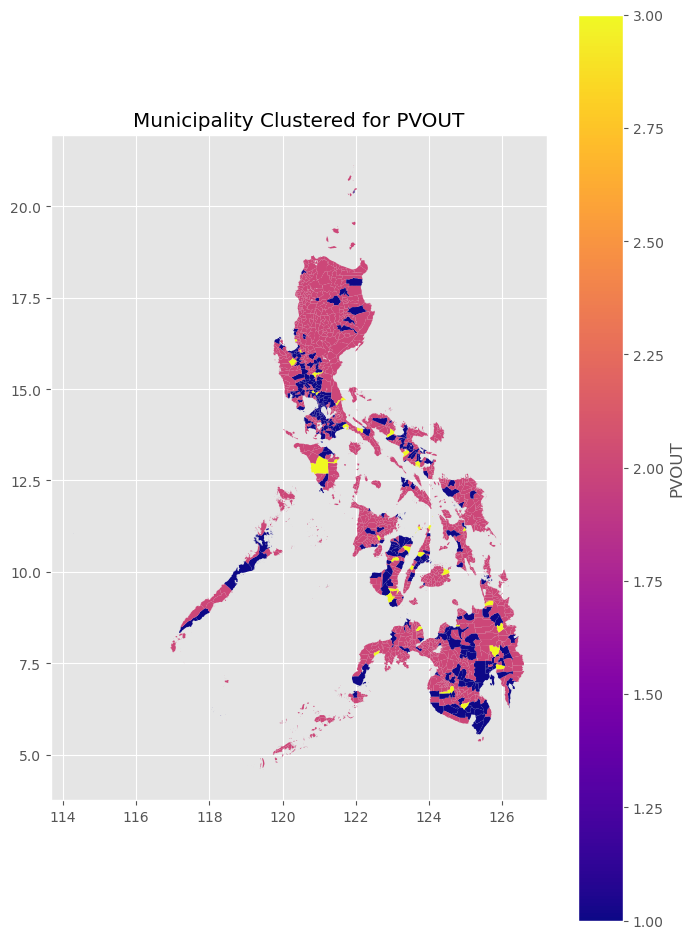

In [145]:
fig, ax = plt.subplots(figsize=(8,12))
ph_cluster_dbscan.plot(column= 'Cluster', ax=ax, legend = True, cmap='plasma', 
             legend_kwds = {'label':'PVOUT'})
plt.title('Municipality Clustered for PVOUT')

In [147]:
ph_cluster_dbscan.to_file(driver='GeoJSON', filename = "wb_ph_cluster_dbscan.geojson")

In [148]:
ph_cluster_dbscan.to_file(driver = 'ESRI Shapefile', filename= "wb_ph_cluster_dbscan.shp")

In [149]:
pv_out_per_cluster_summary = ph_cluster_dbscan.groupby('Cluster').agg({'PVout': ['mean', 'min', 'max','count']})
pv_out_per_cluster_summary

PVout                           
              mean       min        max count
Cluster                                      
1       1311.78237   1.46467 1682.68490   299
2       1280.08675 712.12272 1738.88039  1312
3       1298.49548 897.19561 1674.44340    36

## Comparison of Silhouette Scores 

|**Model**|**Silhouette Scores**|**Number of Clusters**|
|:-|------|------|
|K Means Clustering Model  |0.763591     |5     |
|GMM     |0.628177     |5     |
|DBScan     |0.088279   |  3     |

The model with the highest silhouette score is the K Means Clustering Model with 5 groups. The Average PVOut data for the municipalities will be clustered into 5 total groups 